In [64]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
import re

In [65]:
from main import get_last_data_path
data_dir = "data"
data_path = get_last_data_path(data_dir)

with open(data_path, "rb") as f:
    data = pickle.load(f)

In [66]:
from consts import GEMMA_2
gemma_2_data = data[GEMMA_2]

In [67]:
class_names = ['vector', 'mlp', 'attn', 'resid']
name_mapping = {'vector': 0, 'mlp': 1, 'attn': 2}#, 'resid': 3}
all_vectors = []
mlp_vs_attn = []

for steering_vector, per_vector_data in gemma_2_data.items():
    current_vectors = []
    current_mlp_vs_attn = []

    vec = per_vector_data['meta']['direction']
    current_vectors.append(vec.float())
    current_mlp_vs_attn.append(name_mapping['vector'])
    data_at_position = per_vector_data['all']
    negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
    negative_dots_train, negative_norms_train, negative_agg_train = negative_outputs_train
    positive_dots_train, positive_norms_train, positive_agg_train = positive_outputs_train

    for component_name in negative_agg_train.keys():
        diff_means = positive_agg_train[component_name] - negative_agg_train[component_name]

        if 'ln2' in component_name:
            current_mlp_vs_attn.append(name_mapping['mlp'])
            current_vectors.append(diff_means.float())

        elif 'ln1' in component_name:
            current_mlp_vs_attn.append(name_mapping['attn'])
            current_vectors.append(diff_means.float())

    current_vectors = np.array(current_vectors)
    all_vectors.append(current_vectors)
    mlp_vs_attn.append(current_mlp_vs_attn)

all_vectors = np.array(all_vectors)
all_vectors = all_vectors.transpose(1,0,2)
per_steering_vector = all_vectors.copy()
all_vectors = all_vectors.reshape(all_vectors.shape[0], -1)

mlp_vs_attn = np.array(mlp_vs_attn)[0]

In [68]:
def run_tsne_umap(vectors, is_cosine=True):
    print("Running t-SNE...")
    if is_cosine:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42, metric='cosine')
    else:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    X_tsne = tsne.fit_transform(vectors)

    print("\nRunning UMAP...")
    if is_cosine:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    else:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(vectors)

    return X_tsne, X_umap

In [69]:
def create_graph(X, tsne=False, id=None):
    plt.rcParams.update({
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.figsize": (10, 7),
    })

    method_name = 't-SNE' if tsne else 'UMAP'

    _, ax = plt.subplots()

    colors = ['#E41A1C',  # Red
              '#56B4E9',  # Blue
              '#0d4025']  # Green?

    markers = ['o', 's', '^', 'D']  # Circle, square, triangle, diamond

    for i, cls in enumerate(np.unique(mlp_vs_attn)):
        mask = mlp_vs_attn == cls
        ax.scatter(
            X[mask, 0], X[mask, 1],
            color=colors[i], marker=markers[i],
            alpha=0.85, label=class_names[i], edgecolor='black', linewidth=0.4, s=100
        )
    ax.set_title(f'{method_name} Visualization')
    ax.set_xlabel(f'{method_name} Component 1')
    ax.set_ylabel(f'{method_name} Component 2')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(frameon=True)

    plt.suptitle(f'{method_name}: Steering Vector Components', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save ACL-ready vector file
    plt.savefig(f"./visuals/diff_means_similarity_plots/{method_name}_acl_{id if id else ''}.pdf", bbox_inches="tight")

    plt.show()

Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


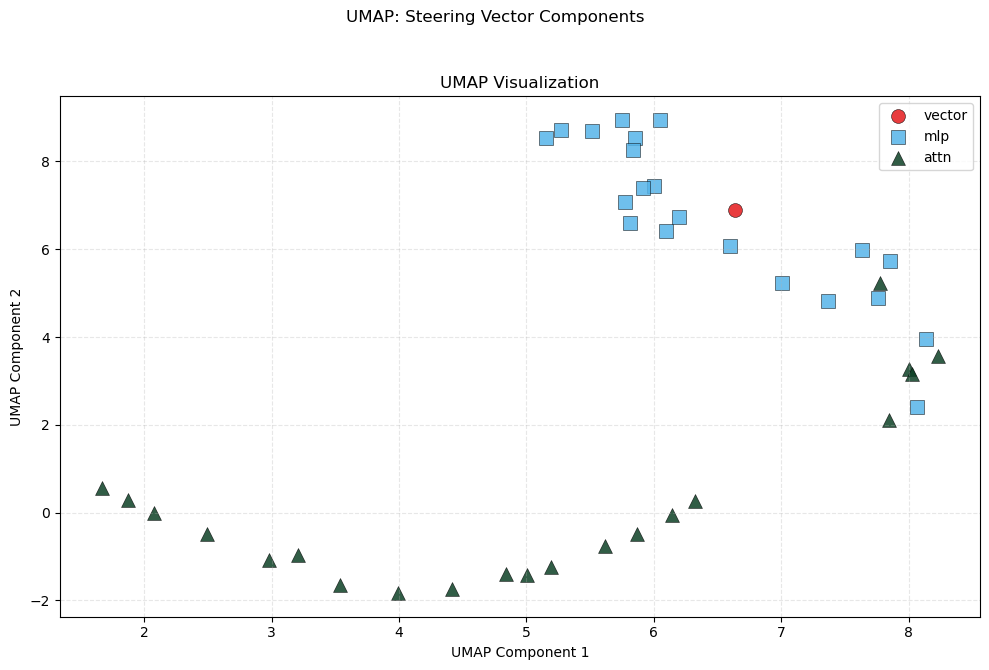

In [70]:
# RUN FOR COSINE SIMILARITY
X_tsne, X_umap = run_tsne_umap(all_vectors)
create_graph(X_umap)

Running t-SNE...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


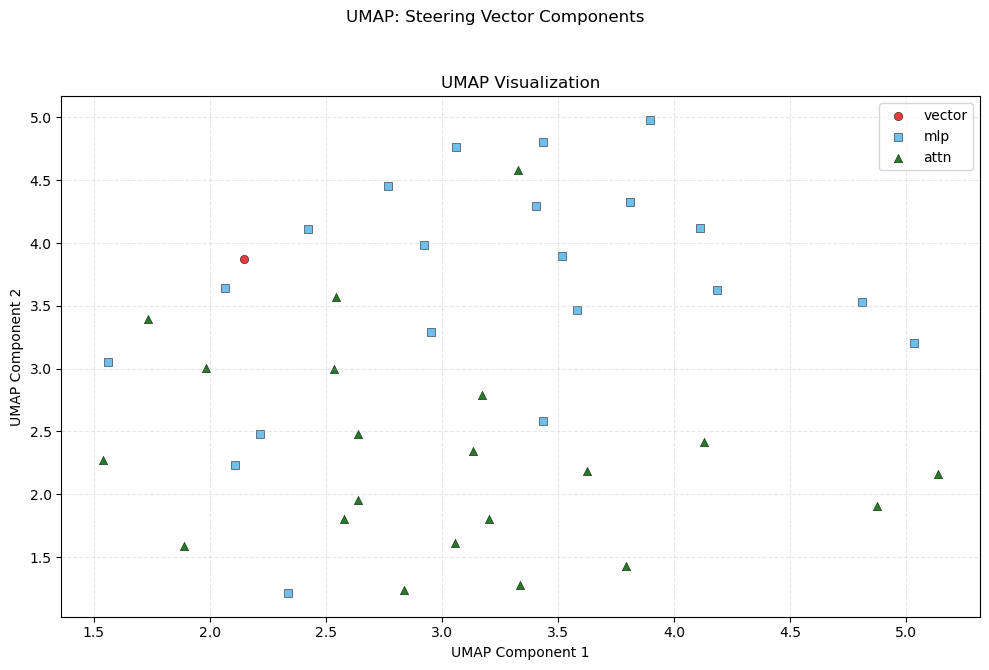

In [ ]:
# RUN FOR EUCLIDEAN DISTANCE
# X_tsne, X_umap = run_tsne_umap(all_vectors,is_cosine=False)
# create_graph(X_umap)

In [9]:
print(len(gemma_2_data.keys()))

25


1161
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


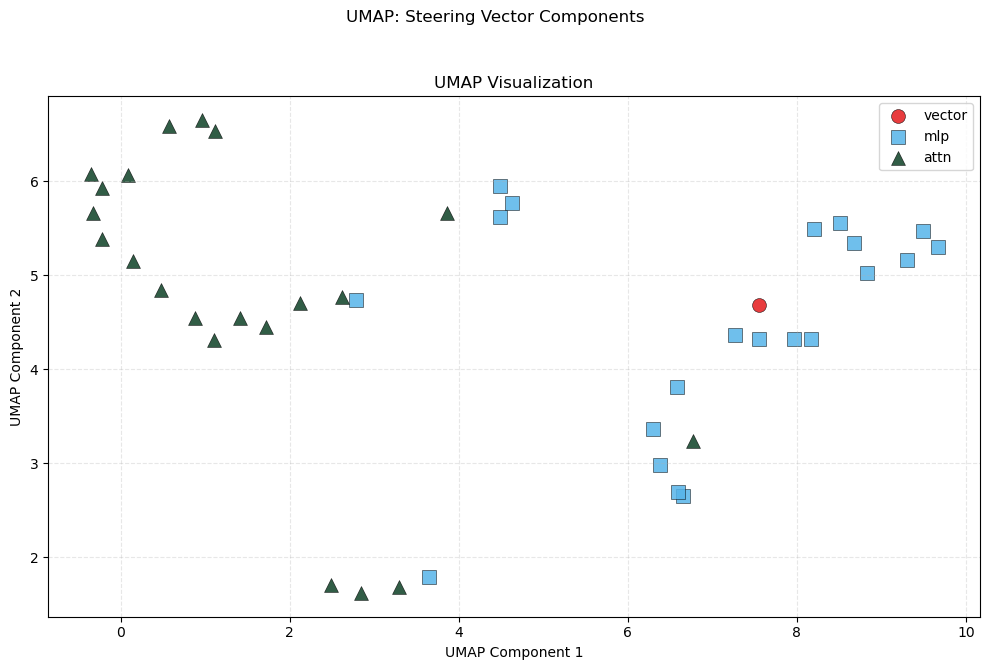

[[ 6.775087    3.2348278 ]
 [ 3.285653    1.6846427 ]
 [ 2.8468359   1.6170284 ]
 [ 2.4846504   1.7073941 ]
 [ 2.6209292   4.7677846 ]
 [ 0.8747652   4.5485168 ]
 [ 1.7227776   4.449001  ]
 [ 1.4148475   4.544182  ]
 [-0.33030564  5.6565776 ]
 [ 1.1049596   4.3071713 ]
 [-0.22774841  5.383127  ]
 [ 0.474328    4.8396072 ]
 [ 1.1177129   6.5337234 ]
 [ 0.13866253  5.1461244 ]
 [ 0.9557552   6.650031  ]
 [ 2.1223056   4.7065997 ]
 [-0.35921776  6.0765867 ]
 [ 0.5687054   6.583803  ]
 [-0.22361062  5.9245734 ]
 [ 3.856076    5.662357  ]
 [ 0.08642989  6.060793  ]]
1200
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


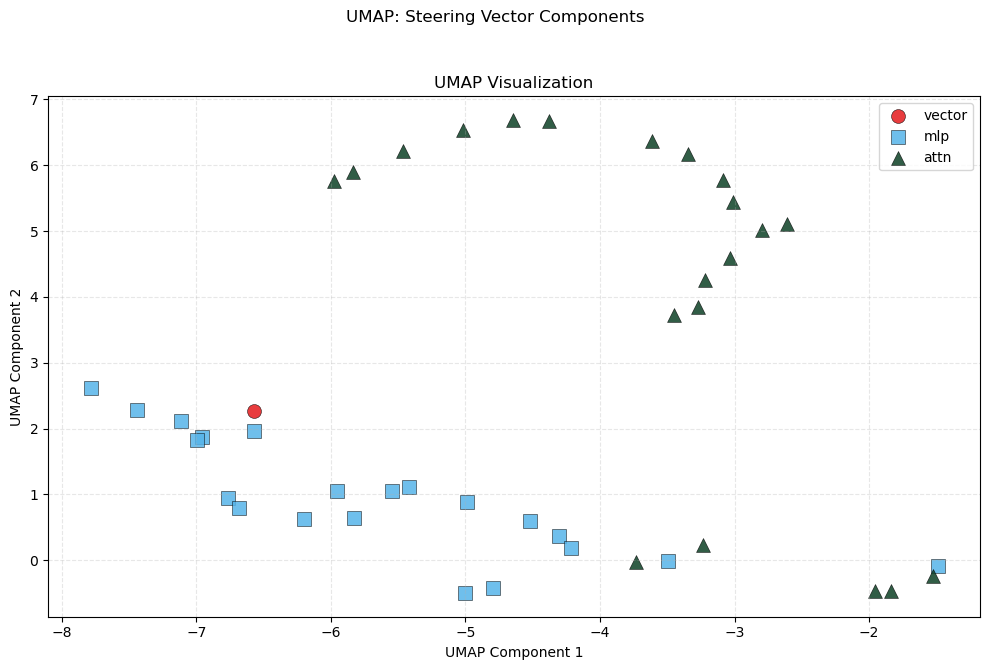

[[-3.7353134  -0.01957621]
 [-1.9544506  -0.4615397 ]
 [-1.838028   -0.4613714 ]
 [-3.2382758   0.23726435]
 [-1.5271306  -0.24430504]
 [-2.6095307   5.109124  ]
 [-3.2176166   4.2567167 ]
 [-3.0355434   4.5968843 ]
 [-3.6116464   6.364239  ]
 [-2.7956877   5.017223  ]
 [-3.348571    6.1701574 ]
 [-3.0093548   5.4352827 ]
 [-5.974973    5.7543197 ]
 [-3.0884001   5.773664  ]
 [-5.8383775   5.900807  ]
 [-3.2703638   3.84027   ]
 [-4.381172    6.6729293 ]
 [-5.4651365   6.2225747 ]
 [-4.648305    6.68676   ]
 [-3.4516358   3.7181218 ]
 [-5.0148463   6.5282426 ]]
137
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


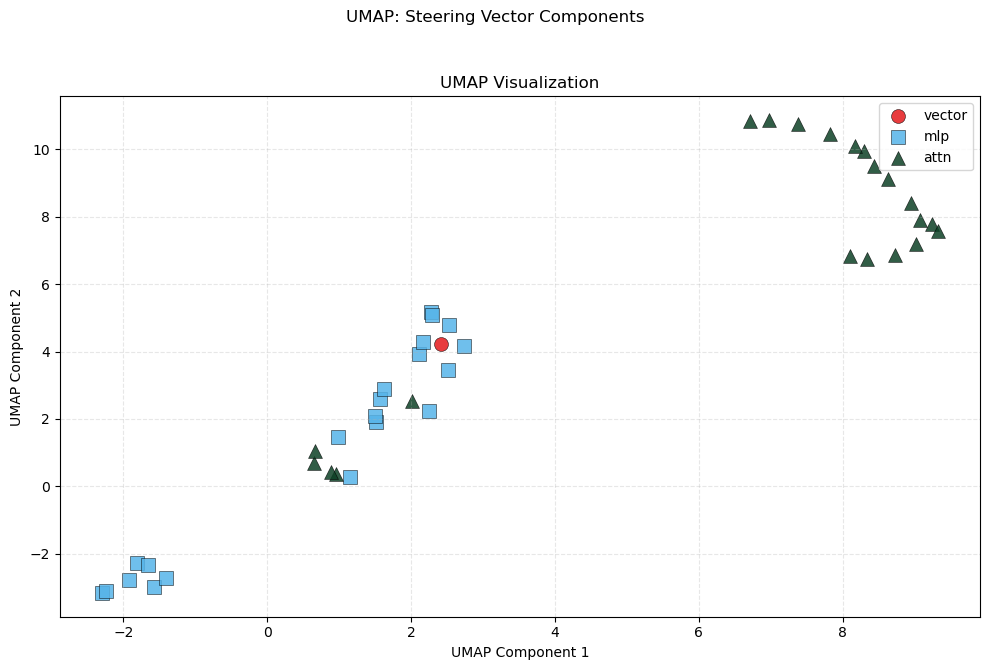

[[ 2.0116932   2.5373285 ]
 [ 0.958673    0.357     ]
 [ 0.6555345   0.7043023 ]
 [ 0.8859142   0.41238636]
 [ 0.6694979   1.045879  ]
 [ 9.238984    7.797651  ]
 [ 8.729643    6.8741193 ]
 [ 9.022992    7.1782274 ]
 [ 8.437761    9.505374  ]
 [ 9.3292465   7.569564  ]
 [ 8.631085    9.126057  ]
 [ 9.083441    7.8998933 ]
 [ 6.705941   10.842473  ]
 [ 8.950586    8.3929615 ]
 [ 6.972423   10.870487  ]
 [ 8.343731    6.7537155 ]
 [ 8.301524    9.949633  ]
 [ 7.3848557  10.756019  ]
 [ 8.169546   10.094745  ]
 [ 8.108345    6.837712  ]
 [ 7.819786   10.450859  ]]
3949
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


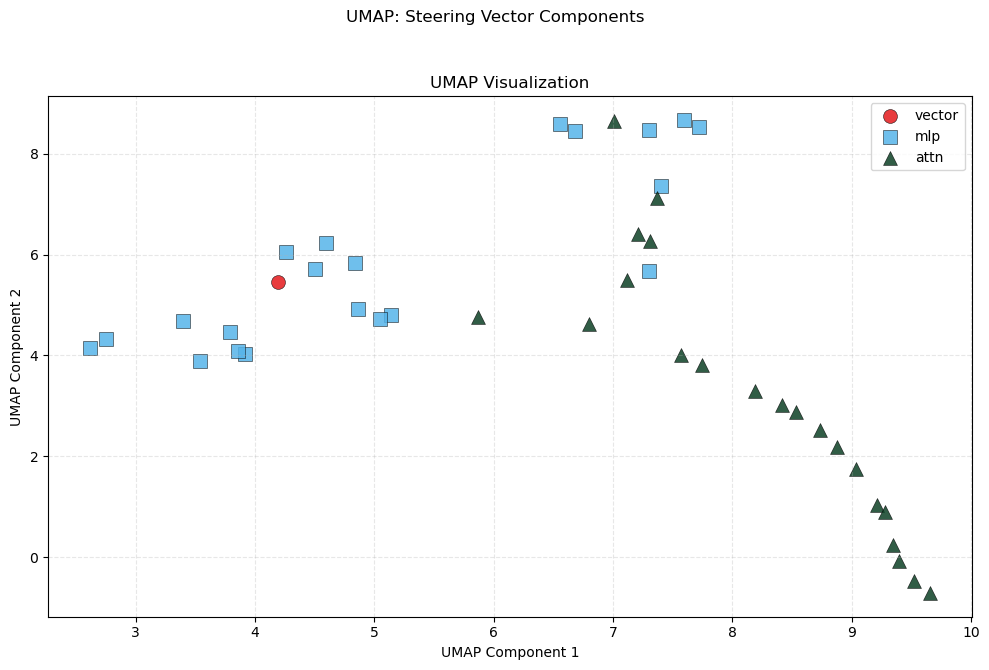

[[ 7.012034    8.649184  ]
 [ 7.312484    6.2692633 ]
 [ 7.2130847   6.3966637 ]
 [ 7.368078    7.1234975 ]
 [ 7.1180334   5.4997754 ]
 [ 8.418336    3.0152364 ]
 [ 7.7486525   3.811276  ]
 [ 7.5678086   4.0059524 ]
 [ 9.032671    1.7520485 ]
 [ 8.18803     3.3047829 ]
 [ 8.875117    2.1827364 ]
 [ 8.530598    2.872017  ]
 [ 9.653651   -0.7063087 ]
 [ 8.73582     2.5177739 ]
 [ 9.524023   -0.4602024 ]
 [ 6.794771    4.628187  ]
 [ 9.208704    1.0450196 ]
 [ 9.3993     -0.0662363 ]
 [ 9.277962    0.9048053 ]
 [ 5.870336    4.770833  ]
 [ 9.348271    0.24056092]]
4287
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


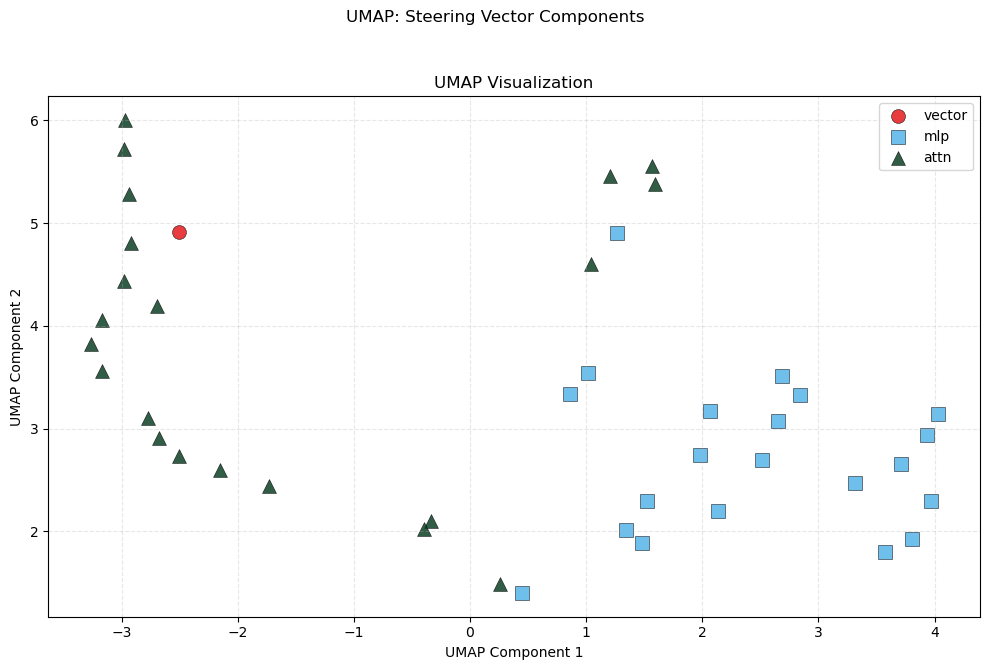

[[ 1.039525    4.602103  ]
 [ 1.5920634   5.3798733 ]
 [ 1.5679748   5.5592976 ]
 [ 1.2057456   5.462856  ]
 [ 0.25956047  1.4909526 ]
 [-2.6799      2.908338  ]
 [-1.730966    2.4409251 ]
 [-2.1549373   2.597247  ]
 [-3.1717176   4.0562725 ]
 [-2.506099    2.7378366 ]
 [-3.2675645   3.820028  ]
 [-2.7694829   3.1080682 ]
 [-2.9713805   6.004606  ]
 [-3.171515    3.5650854 ]
 [-2.9814556   5.720473  ]
 [-0.33554476  2.1017196 ]
 [-2.6953146   4.1960855 ]
 [-2.9359484   5.285664  ]
 [-2.974878    4.4387145 ]
 [-0.39831218  2.024355  ]
 [-2.9219599   4.8052855 ]]
5548
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


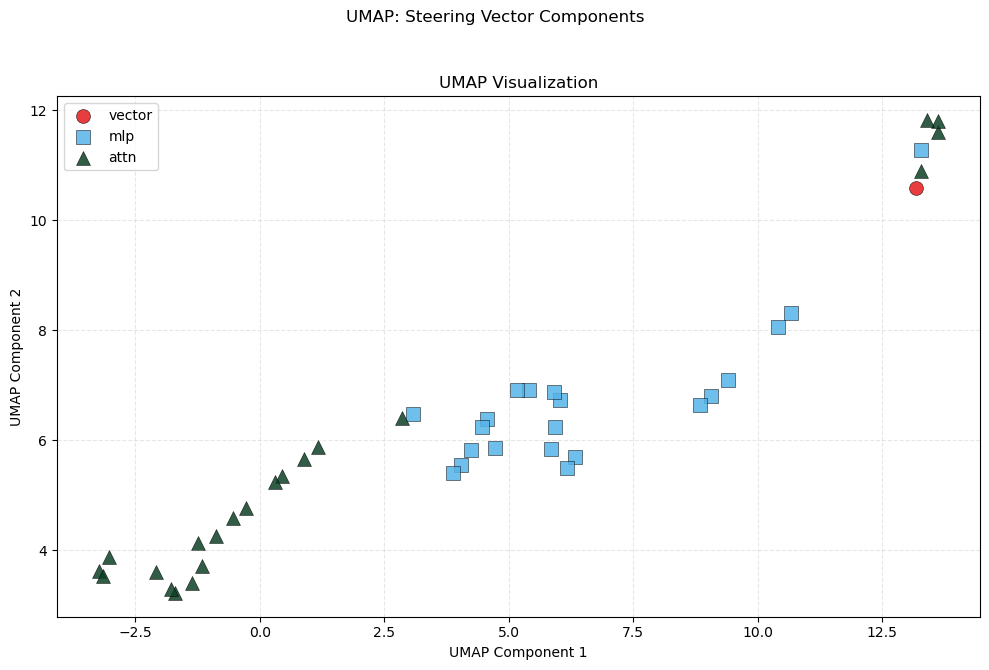

[[13.274155   10.901565  ]
 [13.625137   11.606859  ]
 [13.615766   11.80759   ]
 [13.394857   11.823239  ]
 [ 2.8595917   6.410452  ]
 [-0.54439783  4.5829053 ]
 [ 0.44265783  5.358437  ]
 [ 0.31345335  5.241875  ]
 [-1.3549635   3.400333  ]
 [-0.2812679   4.762111  ]
 [-1.162152    3.708011  ]
 [-0.88432515  4.258644  ]
 [-3.0259342   3.8798938 ]
 [-1.2403152   4.1240754 ]
 [-3.2282104   3.6138191 ]
 [ 0.8890211   5.66393   ]
 [-1.6992329   3.221177  ]
 [-3.1490254   3.530089  ]
 [-1.7817825   3.302369  ]
 [ 1.1671038   5.8700466 ]
 [-2.074995    3.5968907 ]]
6832
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


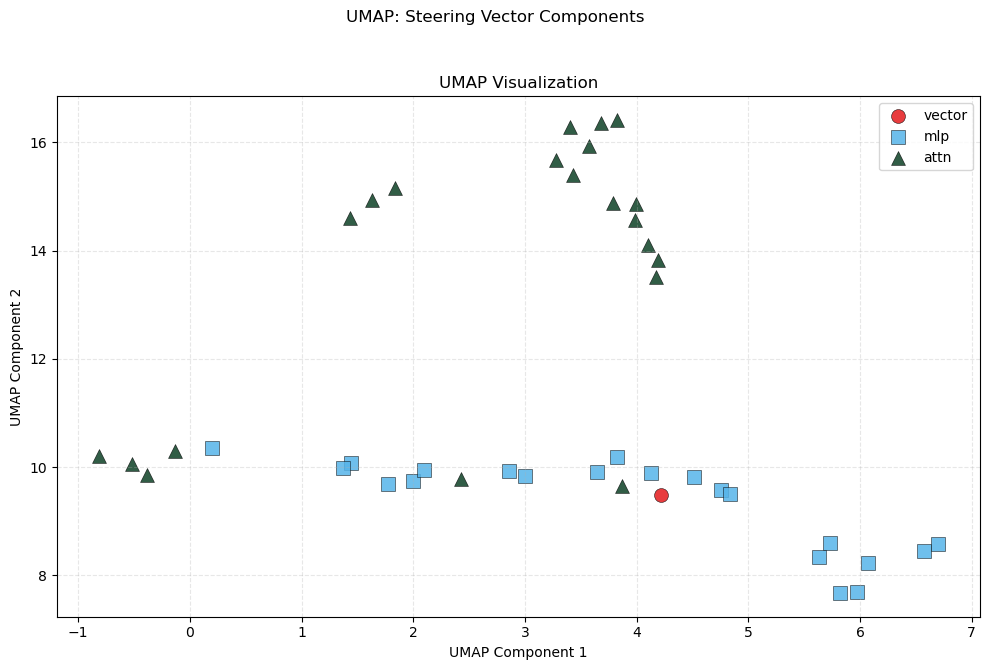

[[ 2.4314067   9.773811  ]
 [-0.38357854  9.850455  ]
 [-0.5137829  10.051425  ]
 [-0.81347495 10.198285  ]
 [-0.12959142 10.291339  ]
 [ 3.9971867  14.85609   ]
 [ 4.189303   13.825276  ]
 [ 4.104309   14.1016865 ]
 [ 3.572977   15.924347  ]
 [ 3.9896328  14.557634  ]
 [ 3.2815852  15.671127  ]
 [ 3.7903805  14.885628  ]
 [ 1.4371656  14.611379  ]
 [ 3.4348109  15.397549  ]
 [ 1.6336643  14.931709  ]
 [ 4.1727686  13.508803  ]
 [ 3.8277755  16.412603  ]
 [ 1.8361087  15.149426  ]
 [ 3.6784937  16.363852  ]
 [ 3.872876    9.651774  ]
 [ 3.4078698  16.290255  ]]
695
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


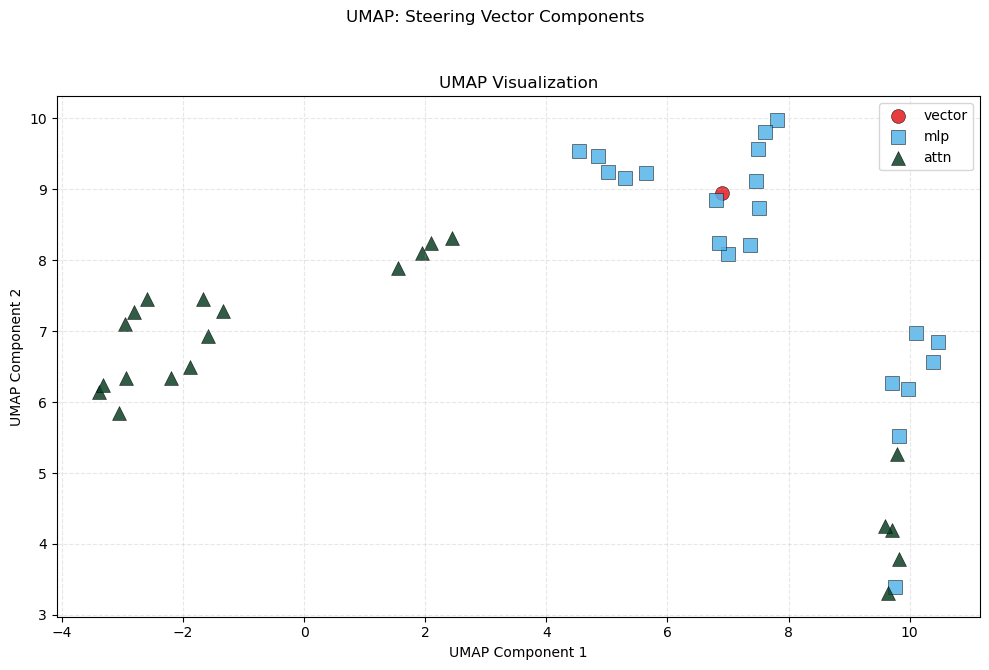

[[ 9.640954   3.3079054]
 [ 9.830603   3.7902493]
 [ 9.70514    4.190103 ]
 [ 9.587321   4.246833 ]
 [ 9.786941   5.268744 ]
 [-1.665873   7.4549727]
 [ 1.9402349  8.09709  ]
 [ 1.5574348  7.8881536]
 [-2.934876   6.3445067]
 [-1.3399197  7.282152 ]
 [-2.1948223  6.3369136]
 [-1.5838884  6.9269943]
 [-2.602497   7.455997 ]
 [-1.8891385  6.502069 ]
 [-2.802972   7.2749157]
 [ 2.1011696  8.245921 ]
 [-3.0591428  5.847854 ]
 [-2.9510617  7.108148 ]
 [-3.3877423  6.1479373]
 [ 2.4368498  8.317668 ]
 [-3.3169148  6.239989 ]]
709
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


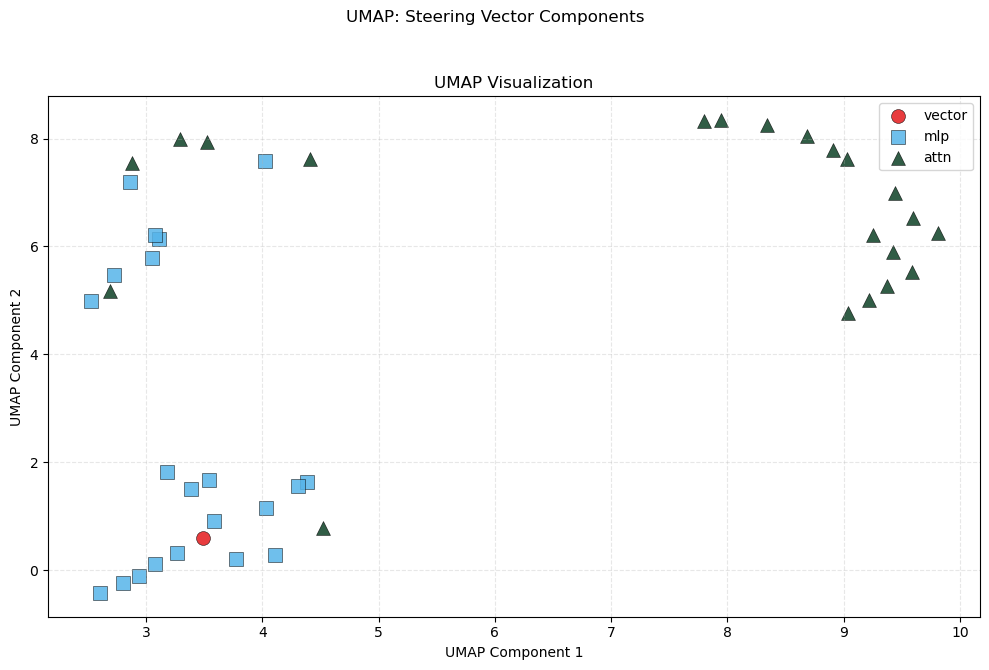

[[2.686744   5.1815357 ]
 [3.5248852  7.9348907 ]
 [3.2895958  7.998045  ]
 [4.4072533  7.620891  ]
 [2.876399   7.5460157 ]
 [9.2564745  6.207973  ]
 [9.214592   4.9998245 ]
 [9.372846   5.260896  ]
 [9.44347    6.9893208 ]
 [9.592249   5.5341625 ]
 [9.594058   6.536154  ]
 [9.427972   5.896476  ]
 [7.7967863  8.32283   ]
 [9.808808   6.25649   ]
 [7.948645   8.344163  ]
 [9.03765    4.7626963 ]
 [9.026803   7.619539  ]
 [8.344037   8.254837  ]
 [8.908629   7.785469  ]
 [4.5166593  0.78453565]
 [8.688376   8.053834  ]]
7988
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


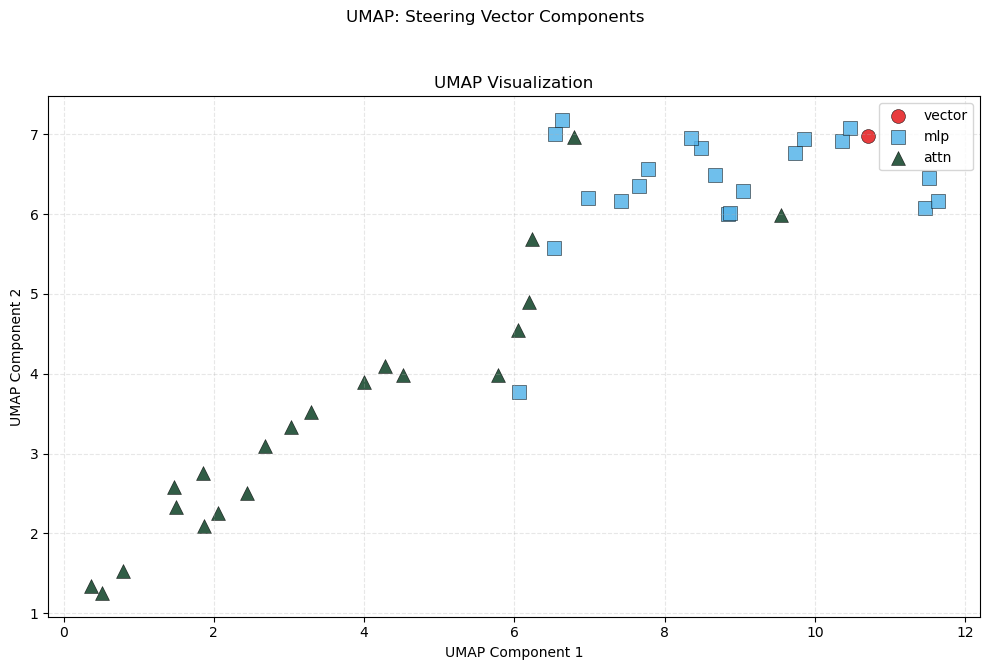

[[6.792545   6.9711866 ]
 [6.1991887  4.896151  ]
 [6.0502367  4.5493045 ]
 [6.2341733  5.6884003 ]
 [5.7876754  3.989244  ]
 [3.0200634  3.3363874 ]
 [4.278886   4.0980554 ]
 [4.0047374  3.9000585 ]
 [1.499287   2.3300786 ]
 [3.2990162  3.5172603 ]
 [1.46433    2.58575   ]
 [2.6854591  3.0933905 ]
 [0.3570376  1.3379778 ]
 [1.857823   2.761826  ]
 [0.50428194 1.2509975 ]
 [4.522332   3.9876242 ]
 [2.4410107  2.505116  ]
 [0.7904379  1.5216155 ]
 [2.0554     2.2499635 ]
 [9.544591   5.9836397 ]
 [1.8742286  2.0856743 ]]
8015
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


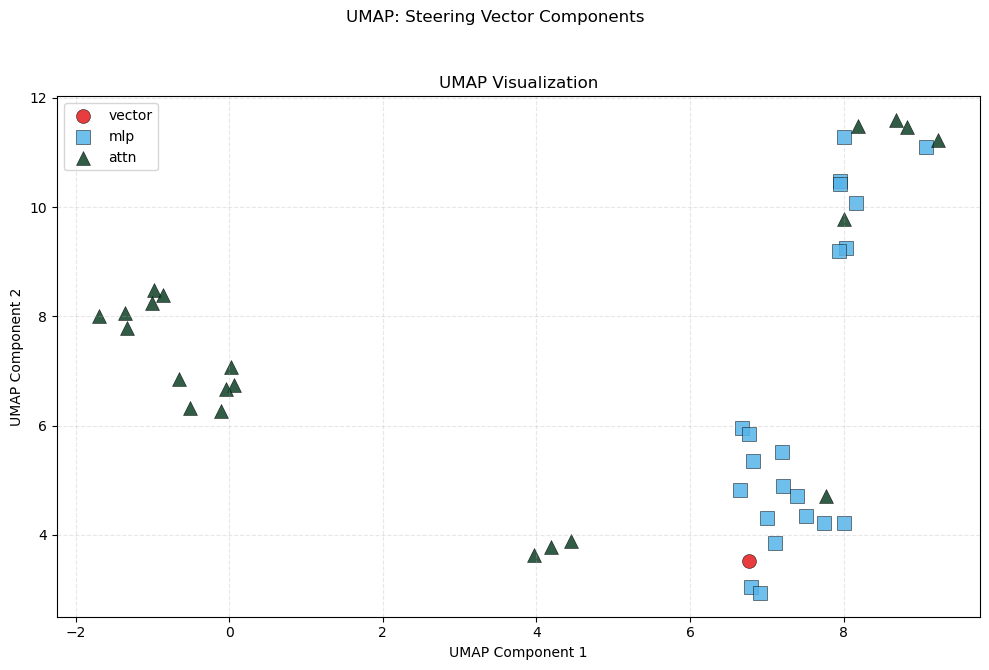

[[ 8.001927    9.776732  ]
 [ 8.830055   11.4597845 ]
 [ 8.68447    11.595836  ]
 [ 9.229251   11.2300415 ]
 [ 8.180559   11.486866  ]
 [-0.9831084   8.479655  ]
 [-1.3330309   7.7849097 ]
 [-1.3566267   8.068914  ]
 [-0.10789196  6.269075  ]
 [-1.0055037   8.2470255 ]
 [-0.5085284   6.3235106 ]
 [-0.86702996  8.390705  ]
 [ 4.447526    3.8930566 ]
 [-0.65883183  6.85254   ]
 [ 4.1914487   3.7799494 ]
 [-1.6953064   8.001798  ]
 [ 0.02812883  7.0647273 ]
 [ 3.9706485   3.6253703 ]
 [ 0.0628155   6.7379365 ]
 [ 7.7671313   4.703533  ]
 [-0.04646671  6.6682467 ]]
1337
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


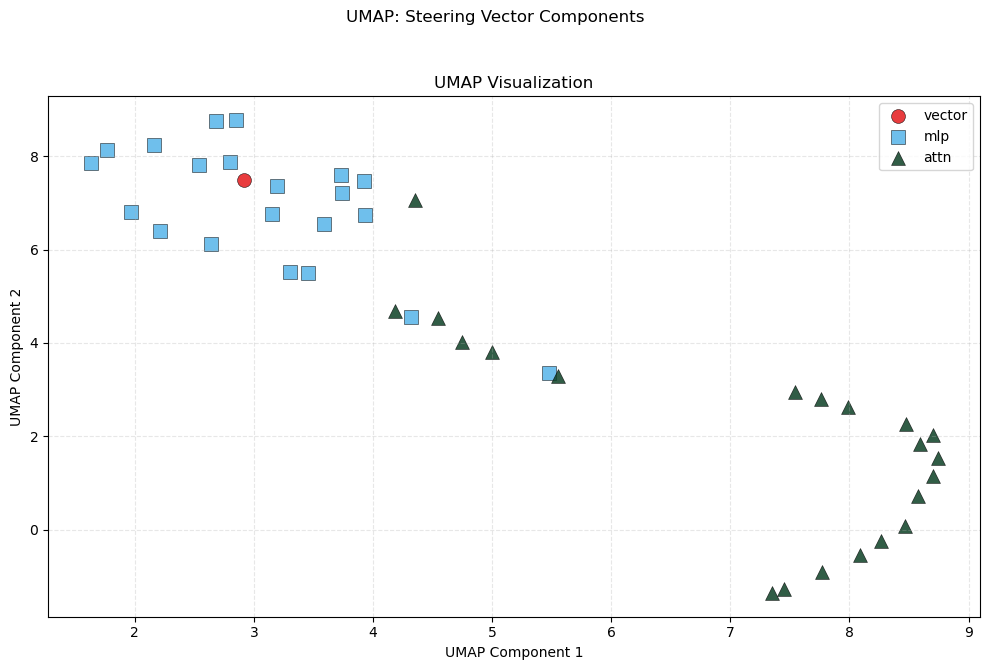

[[ 4.1805186   4.691056  ]
 [ 4.7488627   4.0296803 ]
 [ 5.0001407   3.8068876 ]
 [ 4.547956    4.5341234 ]
 [ 5.5553665   3.302773  ]
 [ 8.589339    1.827207  ]
 [ 7.7574816   2.806406  ]
 [ 7.9884253   2.6264887 ]
 [ 8.579154    0.72110057]
 [ 8.471247    2.2624917 ]
 [ 8.700421    1.1464565 ]
 [ 8.699073    2.0283422 ]
 [ 7.3453054  -1.3552771 ]
 [ 8.74028     1.5396864 ]
 [ 7.4496236  -1.2664558 ]
 [ 7.5467143   2.9520142 ]
 [ 8.467122    0.08561737]
 [ 7.7728543  -0.9087093 ]
 [ 8.262058   -0.23932056]
 [ 4.3534975   7.0671916 ]
 [ 8.085699   -0.54044384]]
14
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


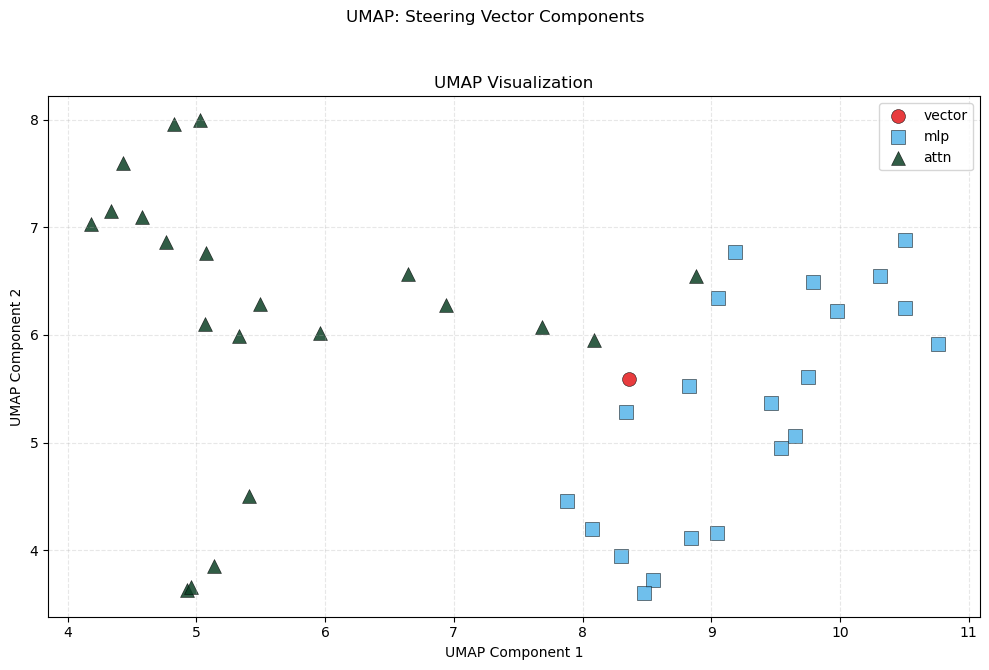

[[5.4083714 4.503817 ]
 [5.1364446 3.8500516]
 [4.926728  3.6284103]
 [4.960247  3.6587007]
 [4.178057  7.030557 ]
 [4.5761633 7.09538  ]
 [5.068779  6.104293 ]
 [5.9627085 6.016454 ]
 [4.4323096 7.597418 ]
 [5.494472  6.2919555]
 [4.337888  7.1538143]
 [5.077447  6.760808 ]
 [5.335308  5.9897323]
 [4.760706  6.8639994]
 [5.0310726 7.998445 ]
 [8.092712  5.956149 ]
 [6.941294  6.2796164]
 [4.8287983 7.9592533]
 [6.644587  6.5671945]
 [8.879716  6.5515656]
 [7.686548  6.074573 ]]
1555
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


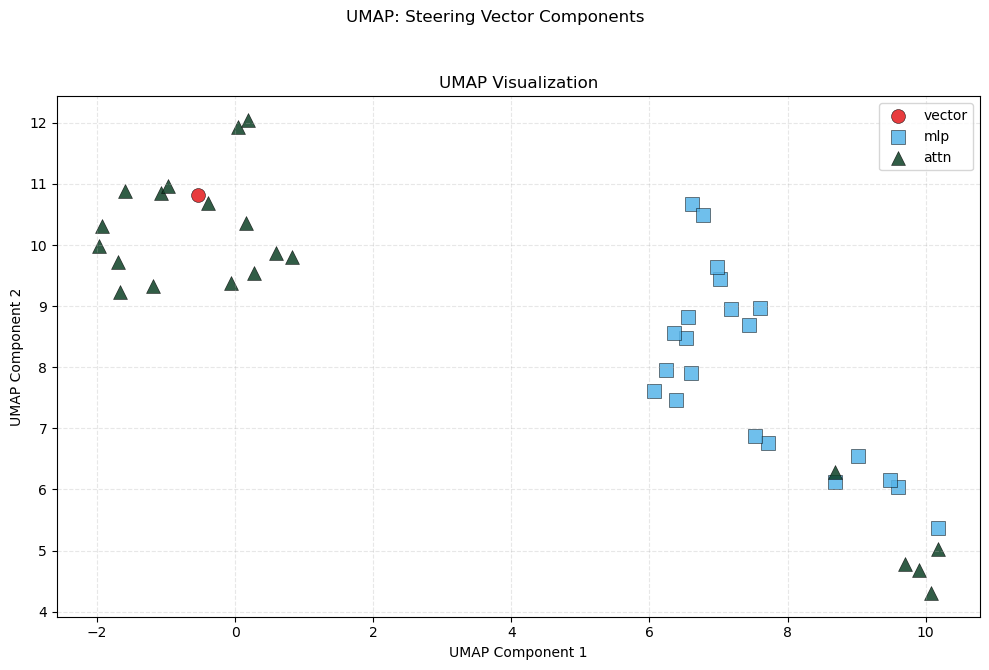

[[ 8.681994    6.2878714 ]
 [ 9.698833    4.7805166 ]
 [ 9.910115    4.68266   ]
 [10.073153    4.3044515 ]
 [10.179897    5.0292454 ]
 [-1.6656893   9.224974  ]
 [ 0.26658848  9.538832  ]
 [-0.0546495   9.370648  ]
 [-1.5922569  10.877602  ]
 [-1.1876236   9.331593  ]
 [-1.9351896  10.318991  ]
 [-1.6996583   9.725007  ]
 [ 0.18527205 12.045949  ]
 [-1.9726197   9.991627  ]
 [ 0.03446805 11.934563  ]
 [ 0.5984261   9.865118  ]
 [-1.0747646  10.852263  ]
 [ 0.15997733 10.354652  ]
 [-0.97494006 10.972022  ]
 [ 0.8293407   9.806009  ]
 [-0.38712534 10.694472  ]]
1752
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


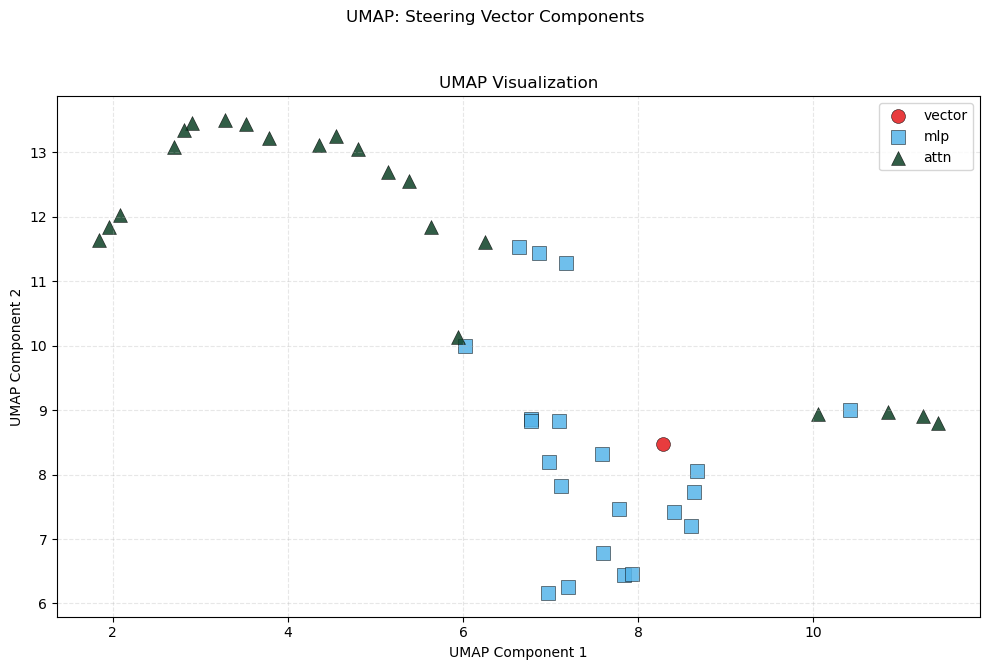

[[10.054427   8.945564 ]
 [10.849679   8.973679 ]
 [11.255792   8.907931 ]
 [11.426719   8.805489 ]
 [ 5.946764  10.136999 ]
 [ 4.5481696 13.250045 ]
 [ 5.387162  12.5528145]
 [ 5.1456847 12.688483 ]
 [ 3.278059  13.503299 ]
 [ 4.8034267 13.054472 ]
 [ 3.526791  13.435763 ]
 [ 4.361431  13.115178 ]
 [ 1.8427811 11.646229 ]
 [ 3.7863827 13.222835 ]
 [ 1.958664  11.83776  ]
 [ 5.6407413 11.842029 ]
 [ 2.90078   13.454133 ]
 [ 2.081131  12.023071 ]
 [ 2.8116868 13.354369 ]
 [ 6.2504644 11.602996 ]
 [ 2.7036703 13.084351 ]]
1818
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


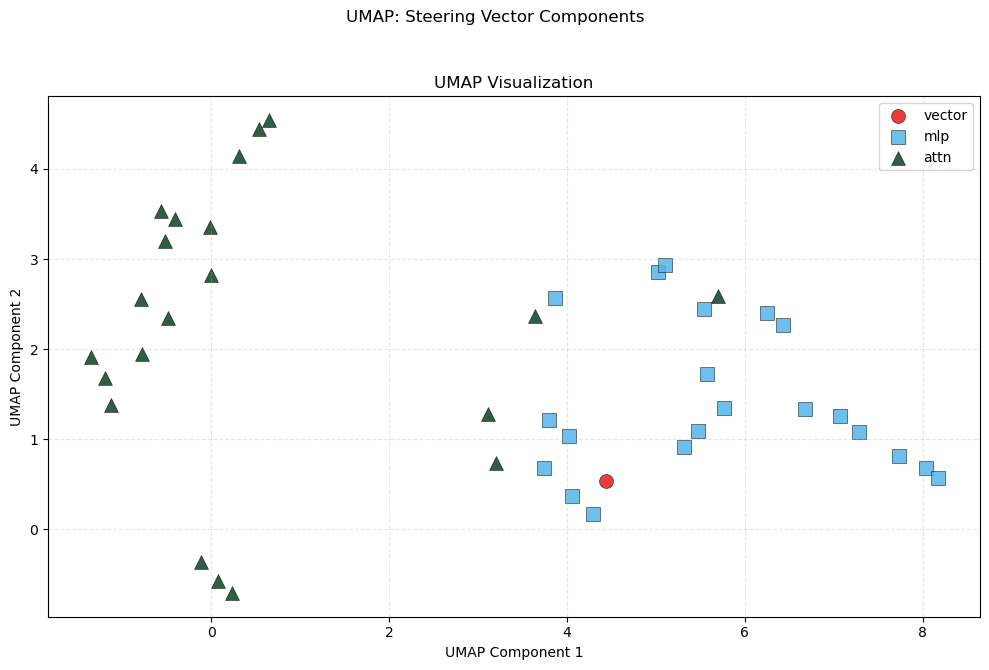

[[ 5.6957178e+00  2.5866609e+00]
 [ 3.1467462e-01  4.1442332e+00]
 [ 5.3272063e-01  4.4439673e+00]
 [ 6.4700752e-01  4.5433345e+00]
 [ 3.6440988e+00  2.3646643e+00]
 [-5.6881130e-01  3.5377767e+00]
 [ 9.0253219e-05  2.8242214e+00]
 [-1.3608241e-02  3.3522518e+00]
 [-7.7823621e-01  1.9482877e+00]
 [-4.1130075e-01  3.4455137e+00]
 [-4.8327109e-01  2.3430979e+00]
 [-5.2303666e-01  3.1998019e+00]
 [ 2.3555358e-01 -7.0620704e-01]
 [-7.8538239e-01  2.5585644e+00]
 [ 8.0850467e-02 -5.7650995e-01]
 [ 3.1150374e+00  1.2834947e+00]
 [-1.3566921e+00  1.9161917e+00]
 [-1.1669520e-01 -3.6245003e-01]
 [-1.1992460e+00  1.6798482e+00]
 [ 3.2058506e+00  7.4120462e-01]
 [-1.1319255e+00  1.3787005e+00]]
2445
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


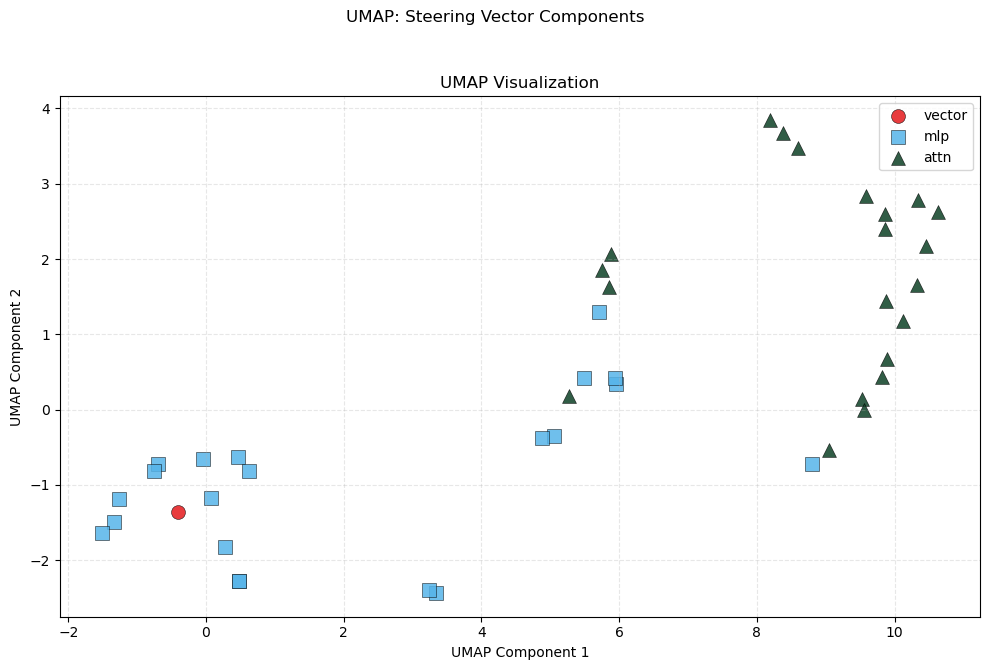

[[ 5.2692127e+00  1.8794332e-01]
 [ 5.8556504e+00  1.6258401e+00]
 [ 5.7518811e+00  1.8596334e+00]
 [ 5.8787718e+00  2.0637045e+00]
 [ 9.0497112e+00 -5.3288299e-01]
 [ 9.8822241e+00  1.4476687e+00]
 [ 9.8228960e+00  4.3323764e-01]
 [ 9.8958683e+00  6.7060554e-01]
 [ 1.0341245e+01  2.7782393e+00]
 [ 1.0126210e+01  1.1723946e+00]
 [ 1.0633431e+01  2.6282802e+00]
 [ 1.0320954e+01  1.6504973e+00]
 [ 8.1922092e+00  3.8464293e+00]
 [ 1.0452081e+01  2.1718948e+00]
 [ 8.3733463e+00  3.6738582e+00]
 [ 9.5218906e+00  1.3864248e-01]
 [ 9.8638134e+00  2.4049344e+00]
 [ 8.5966082e+00  3.4713180e+00]
 [ 9.8582420e+00  2.6014874e+00]
 [ 9.5532751e+00 -6.8636879e-04]
 [ 9.5826616e+00  2.8355665e+00]]
2590
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


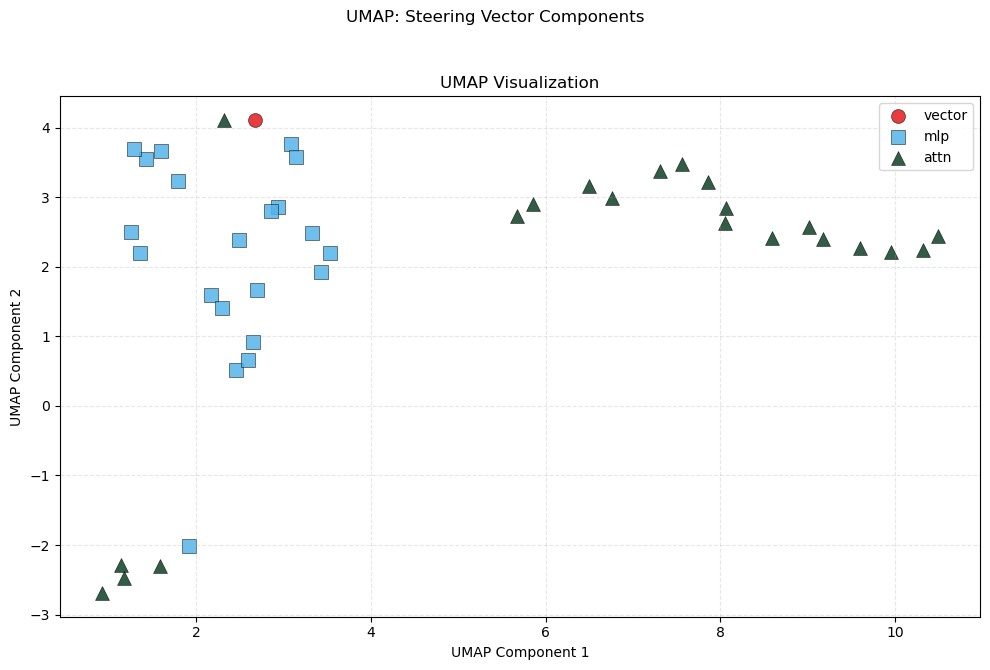

[[ 2.3205807  4.1123834]
 [ 1.1401243 -2.291545 ]
 [ 1.173867  -2.472151 ]
 [ 0.9132545 -2.6909702]
 [ 1.584241  -2.2948492]
 [ 7.559596   3.4780245]
 [ 6.7578616  2.9838407]
 [ 6.4988027  3.156674 ]
 [ 8.595712   2.4216444]
 [ 7.3118367  3.3824067]
 [ 8.055697   2.6346712]
 [ 7.860275   3.2176354]
 [10.4958315  2.4435236]
 [ 8.060077   2.8423905]
 [10.324941   2.2497556]
 [ 5.8574924  2.909483 ]
 [ 9.018276   2.5771973]
 [ 9.957323   2.2149665]
 [ 9.177037   2.3953295]
 [ 5.666411   2.733406 ]
 [ 9.605295   2.2647634]]
294
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


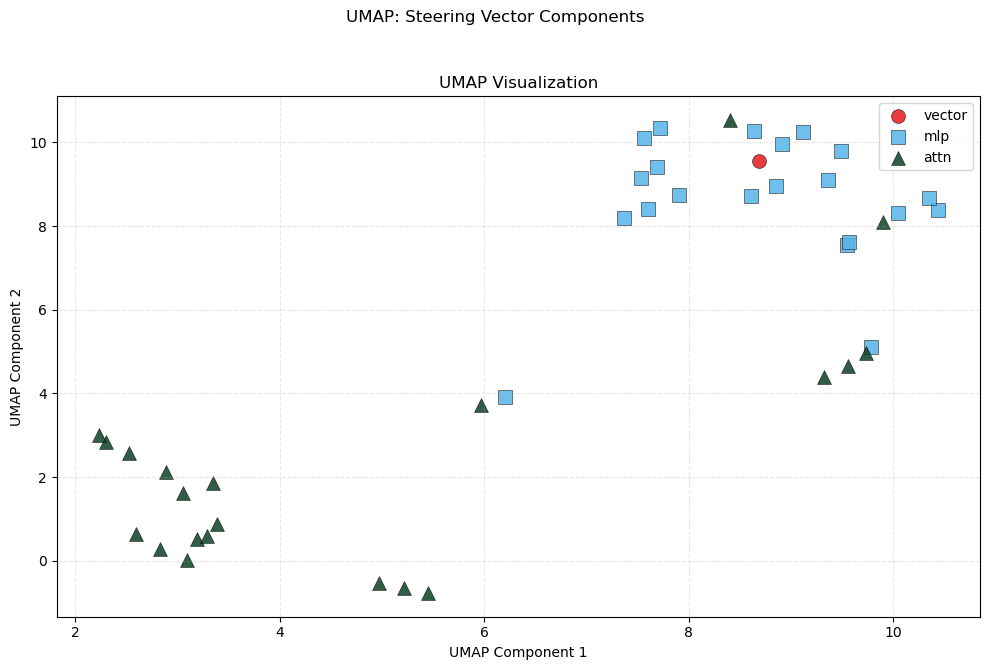

[[ 9.8962498e+00  8.0918865e+00]
 [ 9.3184128e+00  4.3936148e+00]
 [ 9.5605135e+00  4.6521068e+00]
 [ 5.9653101e+00  3.7123585e+00]
 [ 9.7287264e+00  4.9563508e+00]
 [ 3.3431902e+00  1.8672401e+00]
 [ 2.2995043e+00  2.8341424e+00]
 [ 2.5276153e+00  2.5649500e+00]
 [ 3.1902363e+00  5.0714231e-01]
 [ 2.8881583e+00  2.1170442e+00]
 [ 3.2847757e+00  6.0106814e-01]
 [ 3.0564175e+00  1.6256548e+00]
 [ 5.4488988e+00 -7.7366382e-01]
 [ 3.3874354e+00  8.8899541e-01]
 [ 5.2142630e+00 -6.5472108e-01]
 [ 2.2330484e+00  3.0052643e+00]
 [ 2.5980656e+00  6.4308369e-01]
 [ 4.9728055e+00 -5.2229303e-01]
 [ 2.8339930e+00  2.8708705e-01]
 [ 8.4045753e+00  1.0537111e+01]
 [ 3.0896749e+00  9.1327345e-03]]
3306
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


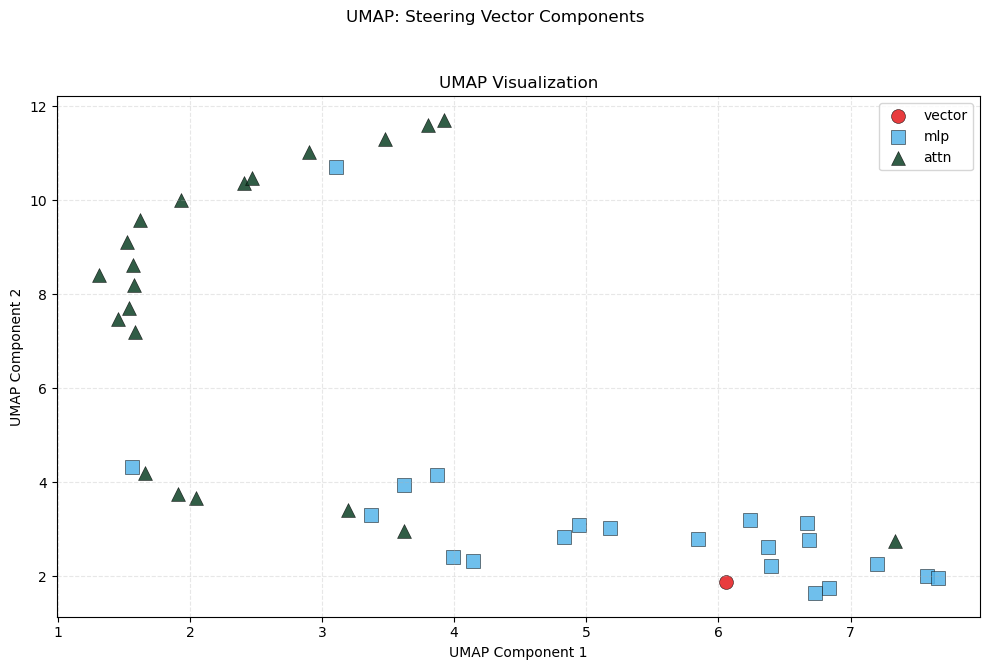

[[ 3.6189175  2.9593475]
 [ 2.0418363  3.6581066]
 [ 1.912264   3.7596288]
 [ 3.1932976  3.4071872]
 [ 1.6608907  4.201845 ]
 [ 1.311131   8.4001665]
 [ 1.4587324  7.4714417]
 [ 1.5417788  7.7033796]
 [ 1.9327731 10.012126 ]
 [ 1.5731494  8.195745 ]
 [ 1.6180083  9.5871935]
 [ 1.5663087  8.620955 ]
 [ 3.9210186 11.704965 ]
 [ 1.522067   9.116411 ]
 [ 3.8002946 11.597824 ]
 [ 1.5826106  7.2002244]
 [ 2.4123058 10.366783 ]
 [ 3.4771163 11.298913 ]
 [ 2.4679513 10.480325 ]
 [ 7.3365593  2.7552629]
 [ 2.9007177 11.031173 ]]
384
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


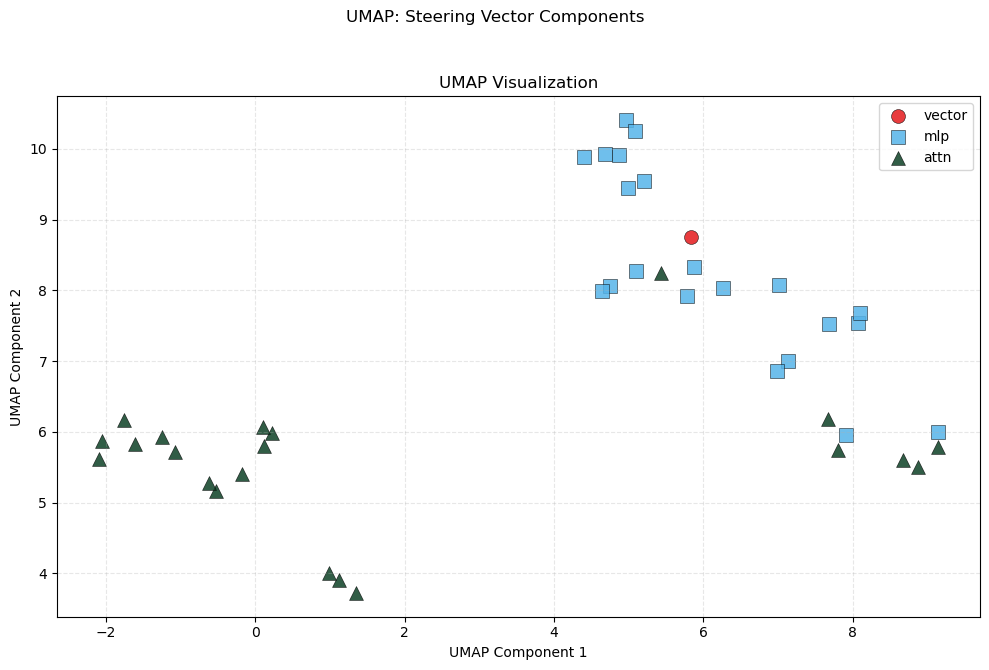

[[ 7.6738725   6.1748843 ]
 [ 8.668998    5.597285  ]
 [ 8.873046    5.4997525 ]
 [ 7.801785    5.7455354 ]
 [ 9.136357    5.792681  ]
 [-0.52436364  5.1642404 ]
 [ 0.21927215  5.9791594 ]
 [ 0.10868535  5.804944  ]
 [-1.6105533   5.8327107 ]
 [-0.17780189  5.4101644 ]
 [-1.2570833   5.920866  ]
 [-0.6252928   5.2780747 ]
 [ 1.3488349   3.7209568 ]
 [-1.0732604   5.7198625 ]
 [ 1.118967    3.9030676 ]
 [ 0.10507156  6.064176  ]
 [-2.095676    5.621963  ]
 [ 0.9881294   3.9995108 ]
 [-2.0568771   5.864731  ]
 [ 5.4312925   8.2417345 ]
 [-1.7576139   6.16983   ]]
541
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


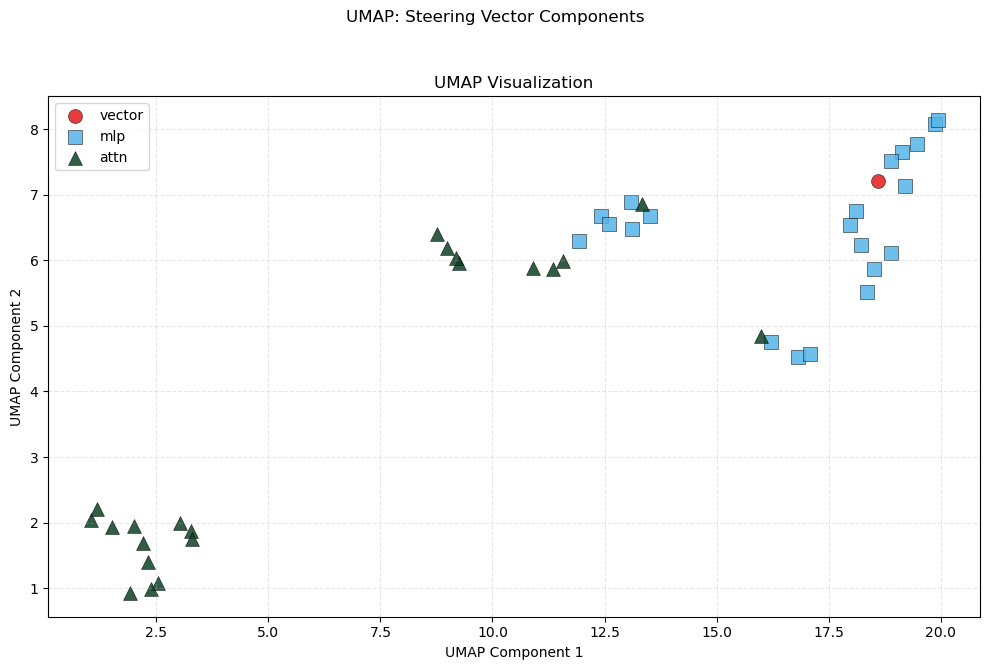

[[13.344787    6.8655214 ]
 [10.912834    5.889992  ]
 [11.354408    5.8727837 ]
 [15.989208    4.845742  ]
 [11.584033    5.993834  ]
 [ 1.0299382   2.0417564 ]
 [ 9.2446575   5.962467  ]
 [ 9.187112    6.0290117 ]
 [ 2.3164155   1.4065009 ]
 [ 1.1769162   2.21192   ]
 [ 2.203538    1.6916046 ]
 [ 1.5065356   1.9397333 ]
 [ 3.0269737   2.0016842 ]
 [ 1.998065    1.9488546 ]
 [ 3.2749326   1.8652117 ]
 [ 8.992823    6.189652  ]
 [ 1.9172016   0.9263471 ]
 [ 3.2965083   1.7470615 ]
 [ 2.3699963   0.99402285]
 [ 8.763448    6.4002557 ]
 [ 2.5404246   1.0803732 ]]
881
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


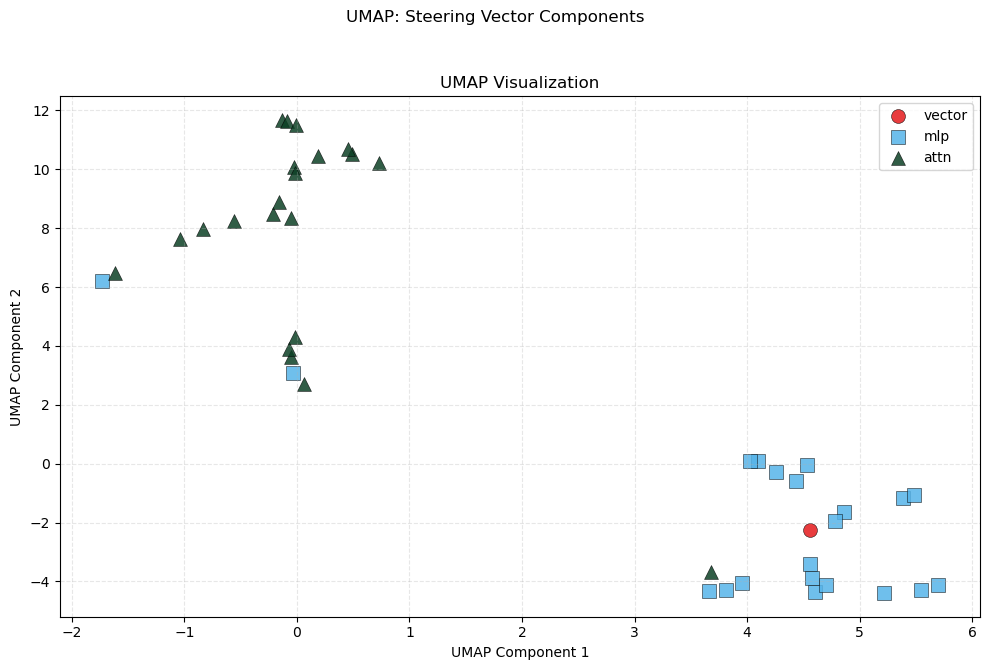

[[ 6.16985224e-02  2.69701743e+00]
 [-5.23310974e-02  3.61165357e+00]
 [-7.13764057e-02  3.90850353e+00]
 [-2.10007671e-02  4.31377935e+00]
 [-1.61304116e+00  6.46490526e+00]
 [-5.36918864e-02  8.35538483e+00]
 [-8.32450688e-01  7.96306372e+00]
 [-5.62988102e-01  8.25511646e+00]
 [ 1.87253863e-01  1.04378901e+01]
 [-2.11958289e-01  8.48862076e+00]
 [-2.99150199e-02  1.00928888e+01]
 [-1.63430870e-01  8.90174389e+00]
 [-1.29015744e-01  1.16752119e+01]
 [-1.48677658e-02  9.87135792e+00]
 [-9.21897590e-02  1.16328754e+01]
 [-1.03424799e+00  7.62528086e+00]
 [ 7.32415140e-01  1.02159786e+01]
 [-4.94287349e-03  1.15041447e+01]
 [ 4.90868419e-01  1.05099945e+01]
 [ 3.68353820e+00 -3.67934418e+00]
 [ 4.58380878e-01  1.07039814e+01]]
9154
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


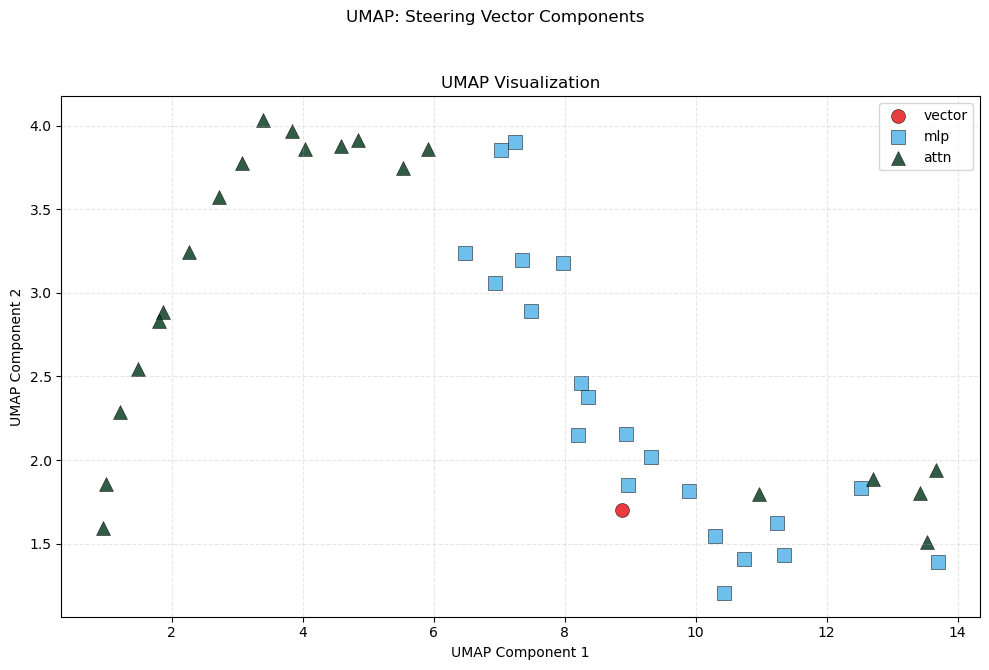

[[10.965613   1.7945654]
 [13.663123   1.9382266]
 [13.429278   1.8018471]
 [13.537859   1.5086969]
 [12.702186   1.8886936]
 [ 3.837478   3.9681036]
 [ 4.8508196  3.9133716]
 [ 4.5844646  3.8776486]
 [ 2.2632933  3.2419856]
 [ 4.040573   3.8605087]
 [ 2.7233331  3.5699785]
 [ 3.398576   4.033351 ]
 [ 0.9517486  1.596033 ]
 [ 3.0767212  3.7766526]
 [ 0.9966171  1.8584414]
 [ 5.5248904  3.7460196]
 [ 1.869084   2.8857749]
 [ 1.2069874  2.2874115]
 [ 1.80227    2.8322363]
 [ 5.912582   3.8584352]
 [ 1.4780108  2.543908 ]]
99
Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


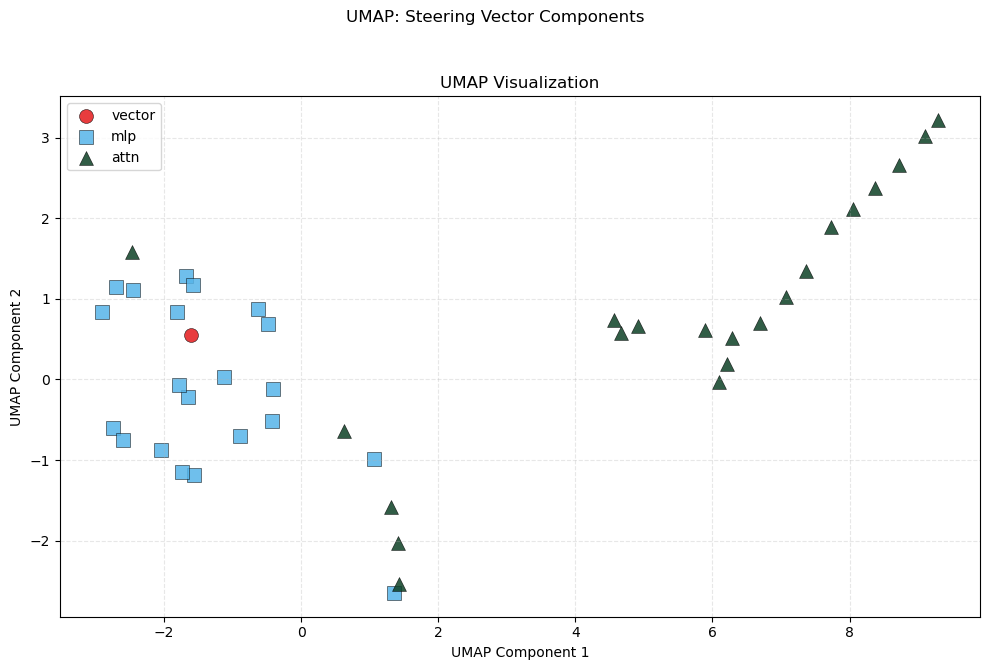

[[ 0.62818724 -0.64062476]
 [ 1.3160955  -1.586706  ]
 [ 1.4153289  -2.0315464 ]
 [ 6.09693    -0.02850907]
 [ 1.4238251  -2.5308723 ]
 [ 6.21057     0.1922248 ]
 [ 4.664603    0.5777854 ]
 [ 4.917707    0.6623468 ]
 [ 7.3579683   1.344567  ]
 [ 5.8889627   0.61637026]
 [ 7.0655136   1.0202752 ]
 [ 6.2913365   0.5132526 ]
 [ 9.292293    3.2182379 ]
 [ 6.693388    0.7058754 ]
 [ 9.095808    3.0149148 ]
 [ 4.559411    0.7346019 ]
 [ 7.734153    1.8934426 ]
 [ 8.715493    2.6552444 ]
 [ 8.047915    2.111748  ]
 [-2.4609318   1.5758028 ]
 [ 8.368659    2.3698604 ]]


In [71]:
rng = np.random.default_rng(42)
counts = [0 for _ in range(21)]
# for study_idx in range(len(gemma_2_data.keys())):
for idx, steering_vector in enumerate(gemma_2_data.keys()):
    # vector_idx = rng.choice(len(gemma_2_data.keys()), size=5, replace=False)
    # vectors = per_steering_vector[:, vector_idx, :]
    vectors = per_steering_vector[:, idx, :]
    print(steering_vector)
    X_tsne, X_umap = run_tsne_umap(vectors.reshape(vectors.shape[0], -1))
    attns = X_umap[[i for i in range(1,len(X_umap),2)]]
    vec_proj = X_umap[0].reshape(1, -1)
    square_errors = np.sum((attns - vec_proj)**2, axis=1)
    counts[np.argmin(square_errors)] += 1
    create_graph(X_umap, id=steering_vector)
    print(X_umap[[i for i in range(1,len(X_umap),2)]])


In [18]:
attns = X_umap[[i for i in range(1,len(X_umap),2)]]
vec_proj = X_umap[0].reshape(1, -1)
square_errors = np.sum((attns - vec_proj)**2, axis=1)
np.argmin(square_errors)

np.int64(0)